# Library Imports

In [1]:
# Import DeepSurv
import sys
sys.path.append('../deepsurv')
import deep_surv

from deepsurv_logger import DeepSurvLogger, TensorboardLogger
import utils
import viz

import numpy as np
import pandas as pd

import lasagne
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import PyTorch for our models
import torch

In [3]:
# check torch GPU usage

if torch.cuda.is_available():
    print(torch.cuda.is_available())
    print(torch.cuda.current_device())
    print(torch.cuda.device(0))
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))


True
0
1
Quadro RTX 5000


# Load Data

In [4]:
base_dataf = "/gpfs/ysm/project/morgan_levine/ym362/smita_dl/"

In [5]:
phenos = pd.read_feather(base_dataf + "phenoFHS.feather" )
dna = pd.read_feather(base_dataf + "FHS_DNAm.feather" )

In [6]:
subset_idxs = (phenos['Lab'] == 2) & (phenos['Cohort'] == "Offspring") 

In [7]:
phenos = phenos[subset_idxs]
dna = dna[subset_idxs]

## Write Train/Test Subset to File

In [8]:
# from sklearn.model_selection import StratifiedShuffleSplit
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
# test = sss.split(phenos.loc[subset_idxs], phenos.loc[subset_idxs,"Dead"])
# train_idxs, test_idxs = next(test)

In [9]:
# phenos.loc[train_idxs].reset_index().to_feather(base_dataf + "phenoFHS_lab2offspring_train.feather")
# phenos.loc[test_idxs].reset_index().to_feather(base_dataf + "phenoFHS_lab2offspring_test.feather")
# dna.loc[train_idxs].reset_index().to_feather(base_dataf + "FHS_DNAm_lab2offspring_train.feather")
# dna.loc[test_idxs].reset_index().to_feather(base_dataf + "FHS_DNAm_lab2offspring_test.feather")

In [10]:
phenos["Dead"].value_counts()

0.0    1800
1.0     209
Name: Dead, dtype: int64

In [11]:
dna.shape

(2009, 443206)

# Cox Regression Model

In order to perform a Cox Regression of our data, we need to compute the PCA, since we aren't able to use the full dataframe

In [13]:
from lifelines import CoxPHFitter
from sklearn.decomposition import PCA


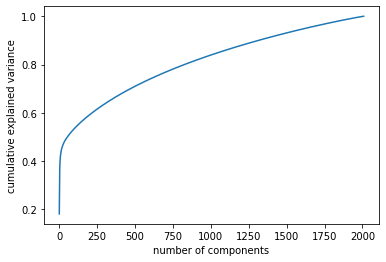

In [14]:
pca = PCA().fit(dna)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [15]:
# run PCA on methylation data since we can't actually run Cox Regression on the whole input
pca = PCA(n_components=750)
dna_transformed = pca.fit_transform(dna)


In [16]:
np.sum(pca.explained_variance_ratio_)

0.7752123580918135

In [17]:
# convert back into a dataframe
dna_transformed = pd.DataFrame(dna_transformed, columns=[f'pca_{x}' for x in range(dna_transformed.shape[1])])

# set the index to the original indices
dna_transformed = dna_transformed.set_index(dna.index)

In [18]:
# prepare data with an event column and a duration column
cox_input = dna_transformed.join(phenos[['Dead',"Time"]])

In [19]:
cox_input

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_742,pca_743,pca_744,pca_745,pca_746,pca_747,pca_748,pca_749,Dead,Time
1,13.716787,-1.558586,-3.220982,-2.286837,2.417527,2.154161,-2.052442,-0.746296,-0.360673,0.327053,...,-0.566043,0.442756,-0.251480,-0.335087,0.383573,0.116564,-0.015906,0.775004,0.0,14420
3,-7.309120,-15.512144,-7.259762,-4.229186,0.062292,1.386955,4.706604,0.221896,2.382856,-1.327049,...,0.155396,0.064469,0.006579,-0.122394,0.064722,-0.501786,0.033239,0.122661,0.0,15724
4,-8.255475,-9.602253,2.543081,-4.733151,0.518922,2.697289,-1.084806,0.243394,-1.425437,9.969855,...,-0.277670,0.263673,0.234006,-0.156529,0.087214,-0.325720,0.589117,-0.571725,0.0,15689
5,-11.085015,3.276686,-3.768612,-7.094097,9.061218,0.555473,-2.715170,0.240786,0.367651,-0.155131,...,-0.058364,0.116822,0.075277,-1.071776,0.340093,0.267220,-0.232270,0.177623,0.0,15341
6,-9.017412,9.672317,0.789139,1.978352,4.327984,-1.975158,-1.146814,-3.507961,-1.217412,-1.556741,...,0.279144,-0.201385,1.045438,0.513803,0.139854,0.039919,-0.269203,0.078471,0.0,14610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2472,13.737763,-1.190169,7.287787,-1.191373,-1.544345,-2.518621,1.125048,-0.086807,-2.602440,-0.255865,...,0.451703,-0.433849,-0.158521,-0.620341,-0.566050,0.329798,0.486978,-0.036293,1.0,14213
2473,13.519987,1.050288,-3.340112,0.038026,-1.363563,5.118804,-0.421466,-0.296798,1.542490,4.958322,...,-0.419482,0.028584,0.166703,0.108642,-0.623372,-0.028936,0.053546,0.269537,0.0,15607
2474,-8.472000,-9.429330,4.876037,-4.129484,-0.607789,2.585021,0.426775,-0.110056,-0.043667,8.973380,...,0.952532,1.042209,0.350676,0.128146,0.038260,-0.031107,0.199550,0.297579,0.0,14527
2476,-10.229832,-0.012168,0.812161,1.385769,3.303200,1.039097,-1.319358,-0.690464,2.484639,-1.617148,...,-0.137790,-0.215120,0.015870,0.063925,-0.166150,0.624300,0.079610,-0.101525,0.0,15716


In [20]:
cph = CoxPHFitter(penalizer=0.1)

In [21]:
cph.fit(cox_input, duration_col='Time', event_col='Dead', batch_mode=True, step_size=0.3, show_progress=True)

Iteration 1: norm_delta = 1.53062, step_size = 0.3000, log_lik = -1533.77078, newton_decrement = 364.80895, seconds_since_start = 2.1
Iteration 2: norm_delta = 0.72873, step_size = 0.3000, log_lik = -1352.44967, newton_decrement = 106.48762, seconds_since_start = 4.1
Iteration 3: norm_delta = 0.46794, step_size = 0.3000, log_lik = -1298.47264, newton_decrement = 46.20866, seconds_since_start = 6.2
Iteration 4: norm_delta = 0.28286, step_size = 0.3900, log_lik = -1269.52789, newton_decrement = 16.65213, seconds_since_start = 8.3
Iteration 5: norm_delta = 0.14398, step_size = 0.5070, log_lik = -1256.91152, newton_decrement = 4.14963, seconds_since_start = 10.3
Iteration 6: norm_delta = 0.05132, step_size = 0.6591, log_lik = -1253.23396, newton_decrement = 0.50842, seconds_since_start = 12.4
Iteration 7: norm_delta = 0.00771, step_size = 0.8568, log_lik = -1252.73467, newton_decrement = 0.01121, seconds_since_start = 14.5
Iteration 8: norm_delta = 0.00001, step_size = 1.0000, log_lik = -1

<lifelines.CoxPHFitter: fitted with 2009 total observations, 1800 right-censored observations>

In [22]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 2009 total observations, 1800 right-censored observations>
             duration col = 'Time'
                event col = 'Dead'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 2009
number of events observed = 209
   partial log-likelihood = -1252.72
         time fit was run = 2021-05-19 16:26:12 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
pca_0       0.01       1.01       0.00            -0.00             0.02                 1.00                 1.02
pca_1      -0.02       0.98       0.01            -0.03            -0.01                 0.97                 0.99
pca_2       0.01       1.01       0.01            -0.00             0.03                 1.00                 1.03
pca_3      -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
pca_4       0.08       1.08       0.01             0.05             0.11                 1.05                 1.11
pca_5      -0.02       0.98       0.02            -0.06             0.02                 0.94                 1.02
pca_6       0.03       1.03       0.02            -0.01             0.07                 0.99                 1.07
pca_7      -0.04       0.97       0.03            -0.09             0.01                 0.92                 1.02
pca_8      -0.00       1.00       0.03            -0.05             0.05                 0.95                 1.05
pca_9       0.03       1.03       0.03            -0.03             0.08                 0.97                 1.09
pca_10      0.08       1.09       0.03             0.02             0.14                 1.02                 1.15
pca_11      0.08       1.08       0.03             0.02             0.14                 1.02                 1.15
pca_12      0.06       1.07       0.03            -0.00             0.13                 1.00                 1.14
pca_13      0.01       1.01       0.04            -0.06             0.08                 0.95                 1.08
pca_14     -0.07       0.93       0.04            -0.15            -0.00                 0.86                 1.00
pca_15     -0.06       0.94       0.04            -0.14             0.01                 0.87                 1.01
pca_16      0.06       1.06       0.04            -0.02             0.13                 0.98                 1.14
pca_17     -0.03       0.97       0.05            -0.12             0.07                 0.89                 1.07
pca_18      0.05       1.05       0.05            -0.04             0.14                 0.96                 1.15
pca_19      0.03       1.03       0.05            -0.07             0.12                 0.93                 1.13
pca_20      0.04       1.04       0.05            -0.05             0.13                 0.95                 1.14
pca_21      0.02       1.02       0.05            -0.08             0.11                 0.93                 1.12
pca_22      0.08       1.08       0.05            -0.02             0.18                 0.98                 1.19
pca_23      0.01       1.01       0.05            -0.09             0.10                 0.91                 1.11
pca_24     -0.08       0.92       0.05            -0.18             0.02                 0.83                 1.02
pca_25      0.03       1.03       0.05            -0.08             0.14                 0.93                 1.15
pca_26      0.10       1.10       0.05            -0.01             0.20                 0.99                 1.22
pca_27     -0.10       0.91       0.05            -0.20             0.01                 0.82                 1.01
pca_28     -0.04       0.96       0.05            -0.15             0.06                 0.86                 1.07
pca_29     

<AxesSubplot:>

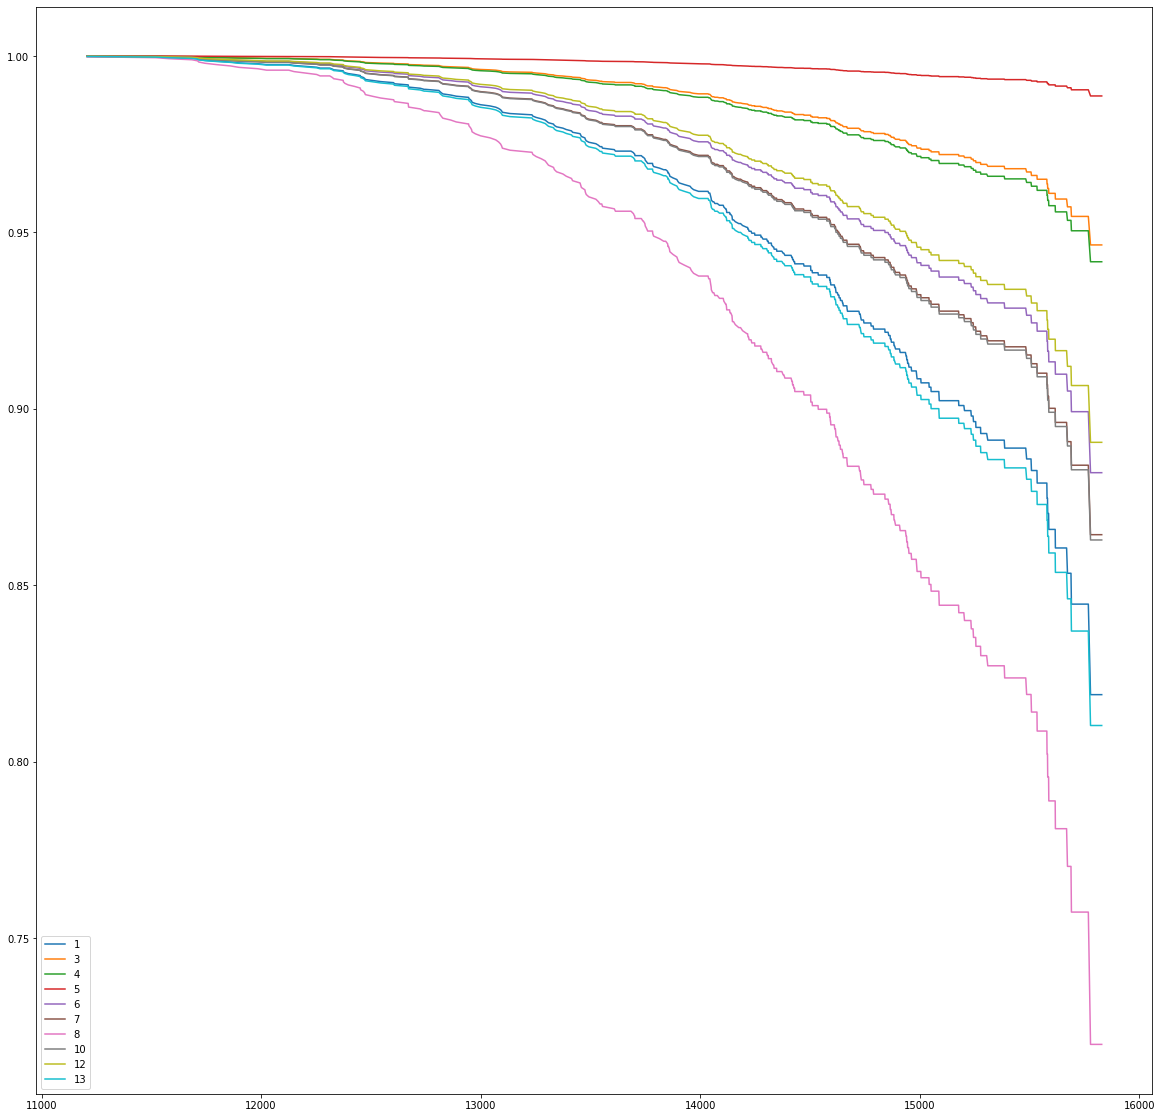

In [23]:
# First train some fitters and plot them
fig = plt.figure(figsize=(20,20))
ax = plt.subplot(111)

# These calls below are equivalent
# add_at_risk_counts(cph)
# cph.plot_survival_function(cox_input)
cph.predict_survival_function(cox_input[cox_input["Dead"] == 0].iloc[:10]).rename(columns={0:'CoxPHFitter'}).plot(ax=ax)
cph.predict_survival_function(cox_input[cox_input["Dead"] == 0].iloc[:10], times=[15000])

<AxesSubplot:xlabel='log(HR) (95% CI)'>

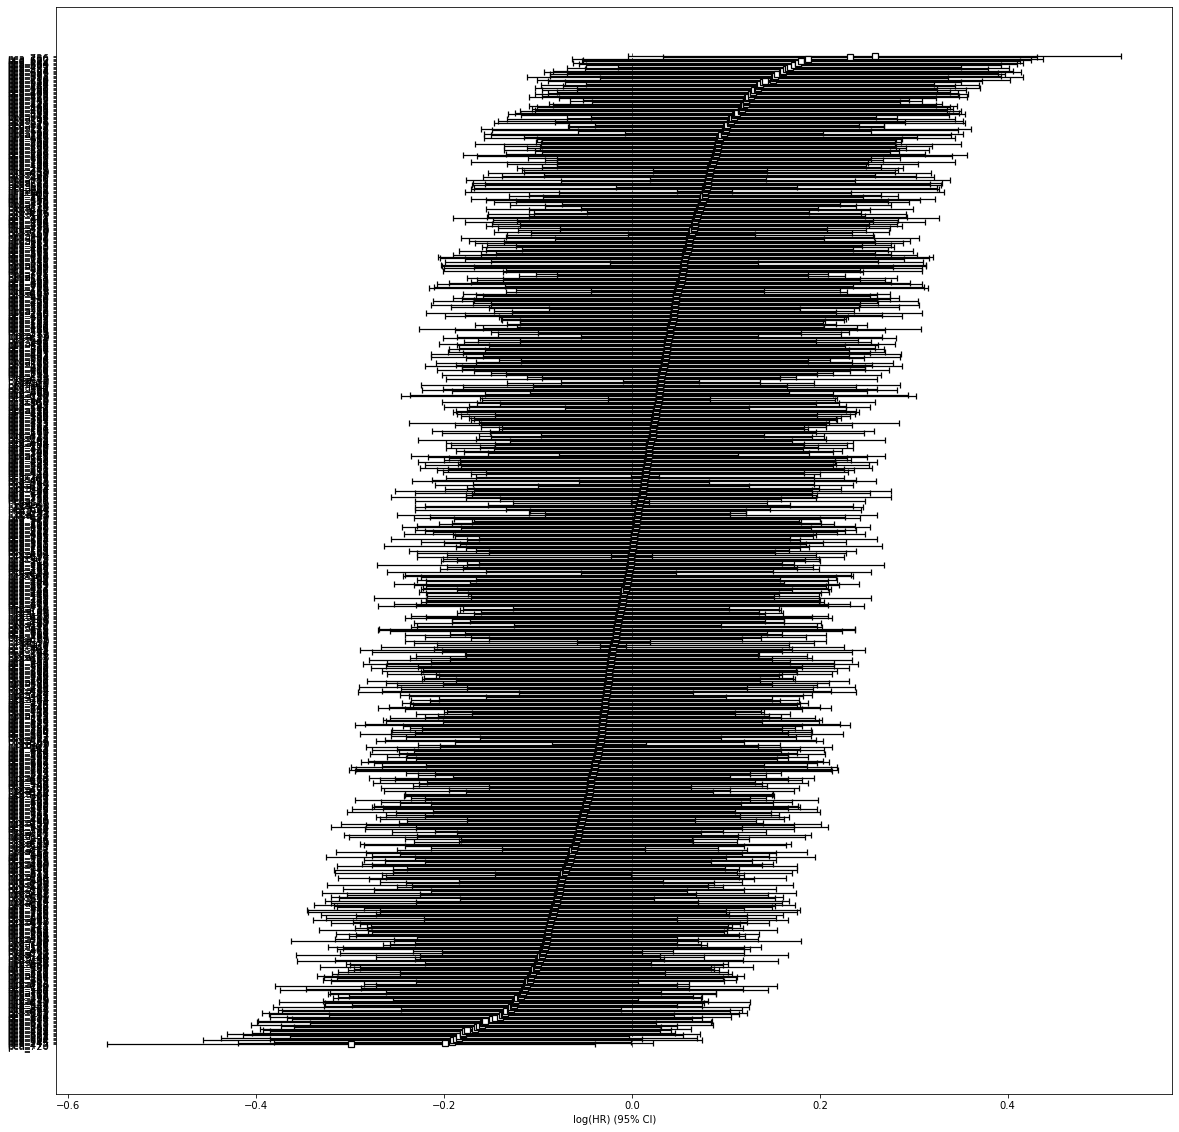

In [24]:
# cph.print_summary()  # access the individual results using cph.summary
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
# print(np.exp(max(cph.params_)))
plt.figure(figsize=(20,20))
cph.plot()

# DeepSurv Model Run on Epigenetic Data

In [25]:
# break up into train and test data
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
idxs = sss.split(phenos, phenos["Dead"])
train_idxs, test_idxs = next(idxs)

In [26]:
train_pcs = cox_input.iloc[train_idxs]
test_pcs = cox_input.iloc[test_idxs]

In [27]:
# event_col is the header in the df that represents the 'Event / Status' indicator
# time_col is the header in the df that represents the event time
def dataframe_to_deepsurv_ds(df, event_col = 'Event', time_col = 'Time'):
    # Extract the event and time columns as numpy arrays
    e = df[event_col].values.astype(np.int32)
    t = df[time_col].values.astype(np.float32)

    # Extract the patient's covariates as a numpy array
    x_df = df.drop([event_col, time_col], axis = 1)
    x = x_df.values.astype(np.float32)
    
    # Return the deep surv dataframe
    return {
        'x' : x,
        'e' : e,
        't' : t
    }



In [28]:
# If the headers of the csv change, you can replace the values of 
# 'event_col' and 'time_col' with the names of the new headers
# You can also use this function on your training dataset, validation dataset, and testing dataset
train_data = dataframe_to_deepsurv_ds(train_pcs, event_col = 'Dead', time_col= 'Time')
test_data = dataframe_to_deepsurv_ds(test_pcs, event_col = 'Dead', time_col= 'Time')

In [29]:
train_data

{'x': array([[-7.341072  , -2.7211597 ,  2.9347167 , ...,  0.07179493,
          0.28209642, -0.5736305 ],
        [13.50706   ,  0.14751062, -4.6508803 , ...,  0.02382365,
          0.41702965, -0.07004608],
        [12.137865  , 11.33061   , -8.569616  , ...,  0.2703638 ,
         -0.5413979 ,  0.7296266 ],
        ...,
        [-8.720502  , -2.0696328 , -5.9945817 , ...,  0.11370752,
          0.0340214 , -0.08876   ],
        [-8.991104  ,  5.4281693 , -5.1093545 , ...,  0.0643038 ,
         -0.21764703,  0.7992466 ],
        [12.461443  ,  4.6071086 , -3.662387  , ...,  0.32529524,
          0.06671319,  0.23405159]], dtype=float32),
 'e': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 't': array([14988., 15674., 15257., ..., 15073., 14882., 14418.], dtype=float32)}

In [39]:
hyperparams = {
    'L2_reg': 8.0,
    'batch_norm': True,
    'dropout': 0.4,
    'hidden_layers_sizes': [100, 100],
    'learning_rate': 1e-05,
    'lr_decay': 0.001,
    'momentum': 0.9,
    'n_in': train_data['x'].shape[1],
    'standardize': True
}

In [40]:
# Create an instance of DeepSurv using the hyperparams defined above
model = deep_surv.DeepSurv(**hyperparams)

# DeepSurv can now leverage TensorBoard to monitor training and validation
# This section of code is optional. If you don't want to use the tensorboard logger
# Uncomment the below line, and comment out the other three lines: 
# logger = None

experiment_name = 'deepsurv_fhs'
logdir = './logs/tensorboard/'
logger = TensorboardLogger(experiment_name, logdir=logdir)

# Now we train the model
update_fn=lasagne.updates.nesterov_momentum # The type of optimizer to use. \
                                            # Check out http://lasagne.readthedocs.io/en/latest/modules/updates.html \
                                            # for other optimizers to use
n_epochs = 2000

# If you have validation data, you can add it as the second parameter to the function
metrics = model.train(train_data, test_data ,n_epochs=n_epochs, logger=logger, update_fn=update_fn)

2021-05-19 13:40:10,191 - Training step 0/2000    |                         | - loss: 25.7842 - ci: 0.5819
2021-05-19 13:40:10,191 - Training step 0/2000    |                         | - loss: 25.7842 - ci: 0.5819
2021-05-19 13:40:10,191 - Training step 0/2000    |                         | - loss: 25.7842 - ci: 0.5819
2021-05-19 13:40:10,191 - Training step 0/2000    |                         | - loss: 25.7842 - ci: 0.5819
2021-05-19 13:40:38,130 - Training step 250/2000  |***                      | - loss: 14.4731 - ci: 0.5797
2021-05-19 13:40:38,130 - Training step 250/2000  |***                      | - loss: 14.4731 - ci: 0.5797
2021-05-19 13:40:38,130 - Training step 250/2000  |***                      | - loss: 14.4731 - ci: 0.5797
2021-05-19 13:40:38,130 - Training step 250/2000  |***                      | - loss: 14.4731 - ci: 0.5797
2021-05-19 13:41:06,053 - Training step 500/2000  |******                   | - loss: 10.2763 - ci: 0.5911
2021-05-19 13:41:06,053 - Training st

Train C-Index: (1999, 0.6350865543548496)


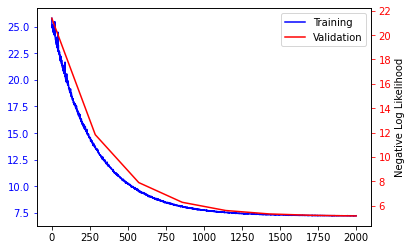

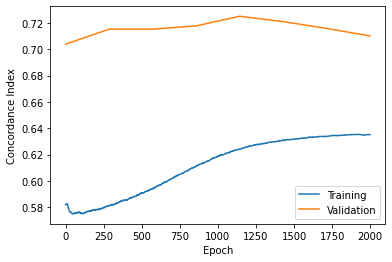

In [41]:
# Print the final metrics
print('Train C-Index:', metrics['c-index'][-1])
# print('Valid C-Index: ',metrics['valid_c-index'][-1])

# Plot the training / validation curves
viz.plot_log(metrics)

# Bookkeeping for NN Training

## Imports

In [42]:
from __future__ import print_function
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from torchvision import utils
from sklearn.metrics import confusion_matrix
import numpy as np 
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

## Load Data

### Define Custom Pytorch Dataset object

In [312]:
# Create PyTorch DNAm dataset from the phenos and DNAm datasets and make the PCs for them to use
class FHSDNAmPCADataset(Dataset):
    """Create FHS DNA methylation data PCs."""

    def __init__(self, PCs, labels, transform=None):
        """
        Args:
            PCs (string): The PCA PCs for the dataset.
            labels (string): the labels for the dataset
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.dataset = PCs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = (self.dataset[idx, :], self.labels[idx])

        if self.transform:
            sample = self.transform(sample)

        return sample

In [313]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        DNA_PCs, death_date = sample
        DNA_PCs = DNA_PCs.astype(float)
        death_date = death_date.astype(float)  
        
        if isinstance(death_date, np.ndarray):
            return (torch.from_numpy(DNA_PCs, torch.from_numpy(death_date.astype(float))))
        else:
            return (torch.from_numpy(DNA_PCs), torch.FloatTensor([death_date]))

## Define Train and Test Functions

In [314]:
from sklearn.metrics import mean_squared_error, r2_score

In [315]:
def train(trainloader, testloader, criterion, lr, num_epochs, ncomponents=300, regularization=False):
    model = TimeToDeathNN(ncomponents=ncomponents).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.8, 0.8))
    
    # initialize loss list
    train_metrics = [[0, 0]]
    test_metrics = [[0,0]]

    # iterate over epochs
    for ep in range(num_epochs):
        model.train()

        # iterate over batches
        for batch_indx, batch in enumerate(trainloader):

            # unpack batch
            data, labels = batch

            # get predictions from model
            pred = model(data.float().to(device))

            loss = criterion(pred.float().cpu(),labels.float().cpu())
                
            if regularization == "l2":
                l2_loss = torch.zeros(1)                
                for name, W in model.named_parameters():                
                    if "bias" not in name:
                        l2_loss += torch.sum(torch.pow(W, 2))
                l2_loss = l2_loss * (reg_lambda / (2*labels.shape[0]))
                loss += l2_loss[0]

            # backpropagate the loss
            loss.backward()

            # update parameters
            optimizer.step()

            # reset gradients
            optimizer.zero_grad()
            
        # compute full train and test accuracies 
        # every epoch
        model.eval() # model will not calculate gradients for this pass
        train_ep_pred = model(data.float().to(device))

        train_mse = mean_squared_error(labels.cpu().detach().numpy(), train_ep_pred.cpu().detach().numpy())
        train_r2 = r2_score(labels.cpu().detach().numpy(), train_ep_pred.cpu().detach().numpy())
        
        # print loss every 5 epochs
        if ep % 10 == 0:
            print("train MSE: {}\t at epoch: {}".format(train_mse, ep))
            print(f"train R^2: {train_r2}")
            test_mse, test_r2 = test(model, device, testloader)
            test_metrics.append([test_mse, test_r2])
            
        train_metrics.append([train_mse, train_r2])

    return np.array(train_metrics),np.array(test_metrics), model
    
    

In [316]:
def test(model, device, test_loader):

    model.eval()
    test_mse = 0
    test_r2 = 0
    
    # stop tracking gradients
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            output = model(data.float())

            test_mse += mean_squared_error(labels.float().cpu().detach().numpy(), 
                                          output.detach().cpu().numpy())

            test_r2 += r2_score(labels.float().detach().cpu().numpy(), 
                                output.detach().cpu().numpy())
            
            
    test_mse /= len(test_loader.dataset)
    test_r2 /= len(test_loader.dataset)
    
    print('\nTest set: Average MSE Loss: {:.4f}, Average R^2: {}\n'.format(
        test_mse, test_r2))

    return test_mse, test_r2

# Data Augmentation with Living Patient Cox Regression

## Create Deep NN

In [289]:
class TimeToDeathNN(nn.Module):
    def __init__(self, ncomponents):
        super(TimeToDeathNN, self).__init__()

        self.fc1 = nn.Linear(ncomponents, 300)
        self.fc2 = nn.Linear(300, 300)
        self.fc3 = nn.Linear(300, 300)
        self.fc4 = nn.Linear(300, 300)        
        self.fc5 = nn.Linear(300, 1)
        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x))
        x = self.dropout(x)
        x = F.leaky_relu(self.fc4(x))
        x = self.fc5(x)

        return x


## Create Dataset

In [290]:
# predict time to death event using Cox Regression
cox_death_estimate = cph.predict_percentile(cox_input, p=0.99)

In [291]:
 from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1)
idxs = sss.split(phenos, phenos["Dead"])
train_idxs, test_idxs = next(idxs)

In [292]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}


train_dataset = FHSDNAmPCADataset(PCs = dna_transformed[train_idxs, :],
                                        labels = cox_death_estimate.iloc[train_idxs].astype(float).to_numpy(),
                                         transform=transforms.Compose([
                                               ToTensor()
                                           ]))


test_dataset = FHSDNAmPCADataset(PCs = dna_transformed[test_idxs, :],
                                        labels = cox_death_estimate.iloc[test_idxs].astype(float).to_numpy(),
                                         transform=transforms.Compose([
                                               ToTensor()
                                           ]))





In [293]:
len(train_dataset)

1808

In [294]:
for i in range(len(train_dataset)):
    data, target = train_dataset[i]
    
    print(data.shape)
    print(i, data.size(), target.size())

    if i == 3:
        break

torch.Size([750])
0 torch.Size([750]) torch.Size([1])
torch.Size([750])
1 torch.Size([750]) torch.Size([1])
torch.Size([750])
2 torch.Size([750]) torch.Size([1])
torch.Size([750])
3 torch.Size([750]) torch.Size([1])


In [295]:
train_loader = DataLoader(train_dataset, batch_size=128,
                        shuffle=True, num_workers=0)

test_loader = DataLoader(test_dataset, batch_size=32,
                        shuffle=False, num_workers=0)

for data, target in train_loader:
    print(data.shape)
    print(target.shape)
    break
    
for data, target in test_loader:
    print(data.shape)
    print(target.shape)
    break    

torch.Size([128, 750])
torch.Size([128, 1])
torch.Size([32, 750])
torch.Size([32, 1])


## Run Model

In [317]:
loss = nn.MSELoss(reduction='sum')
train_metrics,test_metrics, model = train(train_loader, test_loader, loss, 0.0001, num_epochs=300, ncomponents=750)
test(model,device, test_loader)

train MSE: 175202912.0	 at epoch: 0
train R^2: -648.8407517206125

Test set: Average MSE Loss: 6439071.6172, Average R^2: -6.563860809516436

train MSE: 167343632.0	 at epoch: 10
train R^2: -496.4846445755464

Test set: Average MSE Loss: 6338275.2919, Average R^2: -6.460609910680007

train MSE: 134790704.0	 at epoch: 20
train R^2: -517.5135522934651

Test set: Average MSE Loss: 5246023.8086, Average R^2: -5.343770277691604

train MSE: 23237648.0	 at epoch: 30
train R^2: -120.34883091415414

Test set: Average MSE Loss: 1802217.7608, Average R^2: -1.821043223930763

train MSE: 950547.5	 at epoch: 40
train R^2: -3.610738874233835

Test set: Average MSE Loss: 549150.1531, Average R^2: -0.5279676656996418

train MSE: 35216.23828125	 at epoch: 50
train R^2: 0.8392055403172001

Test set: Average MSE Loss: 468238.4115, Average R^2: -0.4452880884545377

train MSE: 202398.1875	 at epoch: 60
train R^2: -0.06889771254182842

Test set: Average MSE Loss: 439762.7368, Average R^2: -0.416155889735494


(419461.04784688994, -0.3956420218598106)

In [297]:
import matplotlib.pyplot as plt

Text(0.5, 0.98, 'Data Augmentation MSE')

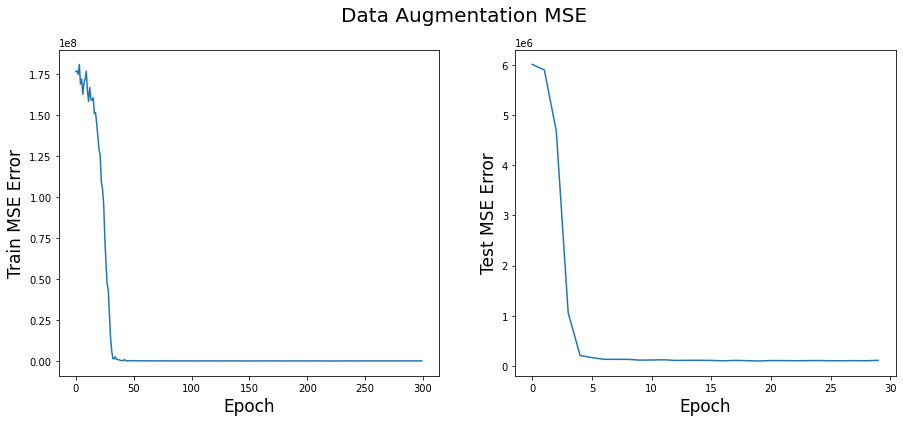

In [298]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))

ax1.plot(np.arange(train_metrics.shape[0] - 1), train_metrics[1:,0])
ax1.set_ylabel('Train MSE Error', size=17)
ax1.set_xlabel('Epoch', size=17)
# ax1.set_title('Death Generalization (Test) MSE', size=20)


ax2.plot(np.arange(test_metrics.shape[0] - 1), test_metrics[1:,0])
ax2.set_ylabel('Test MSE Error', size=17)
ax2.set_xlabel('Epoch', size=17)
# ax1.set_title('Death Generalization (Test) MSE', size=20)

fig.suptitle('Data Augmentation MSE', size=20)



Text(-30, -20, '0.72')

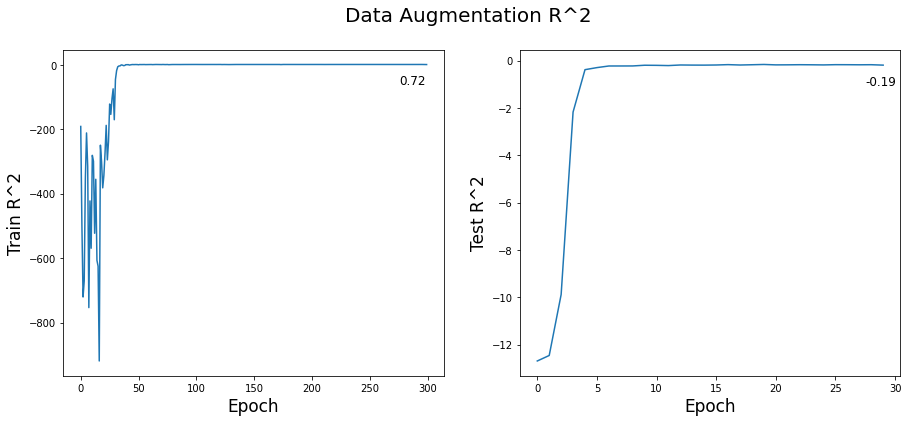

In [299]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
fig.suptitle('Data Augmentation R^2', size=20)

ax2.plot(np.arange(test_metrics.shape[0] - 1), test_metrics[1:,1])
ax2.set_ylabel('Test R^2', size=17)
ax2.set_xlabel('Epoch', size=17)
# ax2.set_title('Death Generalization (Test) MSE', size=20)
# fig.suptitle('Death Event Generalization (Test) MSE', size=20)

ax2.annotate(str(round(test_metrics[-1,1], 2)), xy=(test_metrics.shape[0] -1, test_metrics[-1,1]),
             xytext=(-30,-20), textcoords='offset points',size=12)


ax1.plot(np.arange(train_metrics.shape[0] - 1), train_metrics[1:,1])
ax1.set_ylabel('Train R^2', size=17)
ax1.set_xlabel('Epoch', size=17)
# ax2.set_title('Death Generalization (Test) MSE', size=20)

ax1.annotate(str(round(train_metrics[-1,1], 2)), xy=(train_metrics.shape[0], train_metrics[-1,1]),
             xytext=(-30,-20), textcoords='offset points',size=12)


# Predict Cox Regression on Living and Test Generalization on Dead Patients

We're using the same NN architecture from before that we've already validated, so we don't have to create a new one here. 

## Create Dataset

In [300]:
# predict time to death event using Cox Regression
cox_death_estimate = cph.predict_percentile(cox_input, p=0.99)

In [301]:
# get only living patients death estimates
cox_death_estimate_living = cox_death_estimate[phenos['Dead'] == 0]

In [302]:
# we have to get the right indices since we lost them when creating the PCs 
dna_living_idxs = phenos.reset_index()[phenos.reset_index()['Dead'] == 0].index
dna_dead_idxs = phenos.reset_index()[phenos.reset_index()['Dead'] == 1].index


In [303]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}

train_dataset = FHSDNAmPCADataset(PCs = dna_transformed[dna_living_idxs, :],
                                        labels =cox_death_estimate_living.astype(float).to_numpy(),
                                         transform=transforms.Compose([
                                               ToTensor()
                                           ]))

test_dataset = FHSDNAmPCADataset(PCs = dna_transformed[dna_dead_idxs, :],
                                        labels = phenos[phenos['Dead'] == 1]["Time"].astype(float).to_numpy(),
                                         transform=transforms.Compose([
                                               ToTensor()
                                           ]))


In [304]:
train_loader = DataLoader(train_dataset, batch_size=128,
                        shuffle=True, num_workers=0)

test_loader = DataLoader(test_dataset, batch_size=32,
                        shuffle=False, num_workers=0)

## Run Model

In [305]:
loss = nn.MSELoss(reduction='sum')
train_metrics, test_metrics, model = train(train_loader, test_loader, loss, 
                                           lr=0.0001, num_epochs=300, ncomponents=750)

train MSE: 175807456.0	 at epoch: 0
train R^2: -805.5174401151463

Test set: Average MSE Loss: 6438961.7608, Average R^2: -6.563749193549919

train MSE: 163882816.0	 at epoch: 10
train R^2: -1471.354694801274

Test set: Average MSE Loss: 6321778.9856, Average R^2: -6.444049154930108

train MSE: 127483056.0	 at epoch: 20
train R^2: -426.03975866428436

Test set: Average MSE Loss: 5136523.7129, Average R^2: -5.23560376251896

train MSE: 15449748.0	 at epoch: 30
train R^2: -64.22187587744533

Test set: Average MSE Loss: 1591926.7751, Average R^2: -1.6138817763100788

train MSE: 999800.5	 at epoch: 40
train R^2: -4.200898830742855

Test set: Average MSE Loss: 536192.0431, Average R^2: -0.5197997896295103

train MSE: 132655.15625	 at epoch: 50
train R^2: 0.6112686302480653

Test set: Average MSE Loss: 474676.7703, Average R^2: -0.4546743838224943

train MSE: 87284.78125	 at epoch: 60
train R^2: 0.8061012929188917

Test set: Average MSE Loss: 454847.1100, Average R^2: -0.4345150722585375

tr

In [306]:
import matplotlib.pyplot as plt

Text(0.5, 0.98, 'Death Event Generalization MSE')

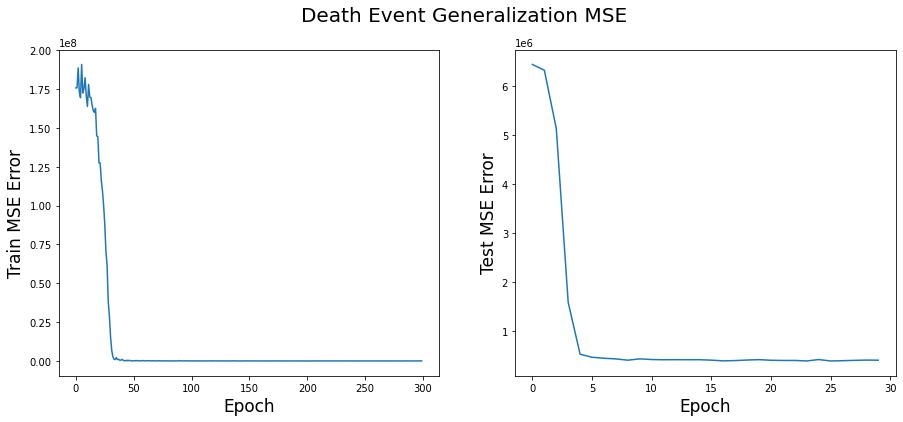

In [307]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))

ax1.plot(np.arange(train_metrics.shape[0] - 1), train_metrics[1:,0])
ax1.set_ylabel('Train MSE Error', size=17)
ax1.set_xlabel('Epoch', size=17)
# ax1.set_title('Death Generalization (Test) MSE', size=20)


ax2.plot(np.arange(test_metrics.shape[0] - 1), test_metrics[1:,0])
ax2.set_ylabel('Test MSE Error', size=17)
ax2.set_xlabel('Epoch', size=17)
# ax1.set_title('Death Generalization (Test) MSE', size=20)

fig.suptitle('Death Event Generalization MSE', size=20)



Text(-30, -20, '0.91')

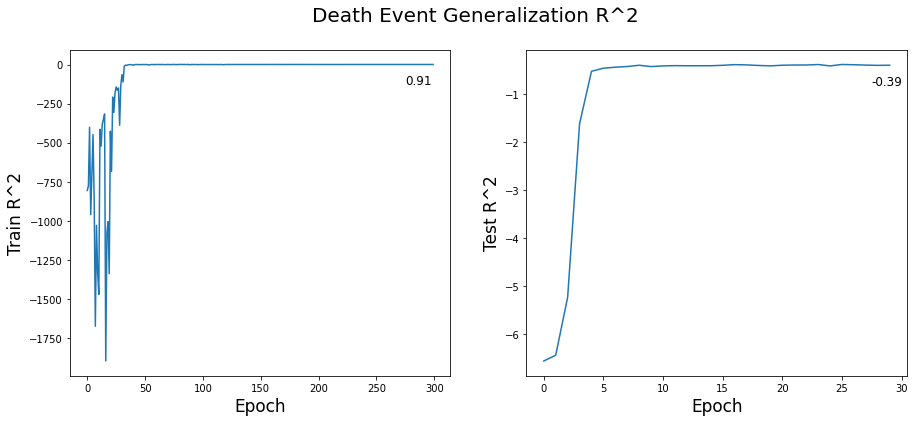

In [308]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
fig.suptitle('Death Event Generalization R^2', size=20)

ax2.plot(np.arange(test_metrics.shape[0] - 1), test_metrics[1:,1])
ax2.set_ylabel('Test R^2', size=17)
ax2.set_xlabel('Epoch', size=17)
# ax2.set_title('Death Generalization (Test) MSE', size=20)
# fig.suptitle('Death Event Generalization (Test) MSE', size=20)

ax2.annotate(str(round(test_metrics[-1,1], 2)), xy=(test_metrics.shape[0] -1, test_metrics[-1,1]),
             xytext=(-30,-20), textcoords='offset points',size=12)


ax1.plot(np.arange(train_metrics.shape[0] - 1), train_metrics[1:,1])
ax1.set_ylabel('Train R^2', size=17)
ax1.set_xlabel('Epoch', size=17)
# ax2.set_title('Death Generalization (Test) MSE', size=20)

ax1.annotate(str(round(train_metrics[-1,1], 2)), xy=(train_metrics.shape[0], train_metrics[-1,1]),
             xytext=(-30,-20), textcoords='offset points',size=12)
